<a href="https://colab.research.google.com/github/robinanwyl/breast_cancer_classifier/blob/main/BENG203_CSE283_ClassifierTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BENG 203/CSE 283 SP25 Final Project - Breast Cancer Classifier - Training

-  Training SVM, random forest, and MLP classifiers
***

In [1]:
from google.colab import drive
drive.mount('/content/drive')
filepath = "/content/drive/My Drive/BENG203_CSE283_Project/"

Mounted at /content/drive


Importing required libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

Loading Data

In [ ]:
# Cancer data
cancer_tpm = pd.read_csv(f"{filepath}/Data/pnas_tpm_96_nodup.txt", sep="\t", header=None, index_col=0)
cancer_read_counts = pd.read_csv(f"{filepath}/Data/pnas_readcounts_96_nodup.txt", sep="\t", header=None)
cancer_tpm.columns = [f"C{i}" for i in range(1, cancer_tpm.shape[1] + 1)]

# Normal data
normal_tpm = pd.read_csv(f"{filepath}/Data/pnas_normal_tpm.txt", sep="\t")
normal_read_counts = pd.read_csv(f"{filepath}/Data/pnas_normal_readcounts.txt", sep="\t")
normal_tpm.columns = [f"N{i}" for i in range(1, normal_tpm.shape[1] + 1)]

In [ ]:
cancer_tpm.head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,...,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,7.071605,60.610797,58.255903,29.917356,24.500322,25.311091,37.394452,15.354658,24.839014,24.591295,16.221636,17.336068,36.677114,65.075271,35.330255,22.640907,3.517080,12.223762,11.574473,4.743493,46.912704,0.000000,11.208118,6.162279,13.624210,28.776199,10.678957,30.328963,3.900178,69.498909,12.846356,7.294690,7.405749,10.578452,46.269032,35.947689,19.508187,0.000000,18.512848,3.859387,...,6.814049,36.355066,0.000000,0.0,23.612096,19.039814,26.137844,37.507027,25.574938,15.913527,0.000000,34.033629,11.676898,23.721679,25.611765,18.832925,23.350256,16.205009,7.215348,0.000000,36.507707,17.289560,32.301777,29.103620,0.000000,2.588885,19.837727,2.158396,32.471569,32.648601,14.134044,10.803910,6.068982,12.714350,15.983392,0.000000,38.189128,15.608352,51.519267,30.805593
ENSG00000000005,13.279391,47.424080,60.455497,6.482332,53.675826,31.686900,32.409716,0.000000,48.976056,46.178684,53.308058,65.108960,18.231353,19.639509,18.659477,7.086026,0.000000,68.863059,16.301315,20.041993,7.773077,0.000000,6.314139,8.678862,44.772312,12.470145,30.080167,17.085944,0.000000,279.660651,0.000000,30.821197,20.860294,9.932356,0.000000,6.328524,0.000000,0.000000,20.858575,10.871005,...,0.000000,20.480773,14.821242,0.0,27.712436,44.692317,22.653631,22.639002,25.728115,6.403536,36.232961,51.127953,19.734683,50.113888,30.918195,19.893008,27.405127,11.411447,5.080994,6.696563,47.461763,6.957245,0.000000,11.711173,11.780192,14.584590,11.175664,0.000000,36.585979,91.963607,0.000000,12.172853,136.759411,28.650721,0.000000,0.000000,5.976111,6.280734,241.863225,0.000000
ENSG00000000419,0.000000,0.000000,23.040206,8.646690,20.456404,42.266702,21.615428,11.538256,18.665274,76.996356,50.790611,0.000000,0.000000,26.196859,16.593072,28.355844,13.214546,103.337379,43.488181,17.822485,0.000000,29.726675,0.000000,11.576610,51.189554,24.950621,120.370509,60.775187,0.000000,0.000000,28.960178,41.111953,9.275082,0.000000,15.804026,0.000000,64.134982,0.000000,34.778693,0.000000,...,25.602080,54.638020,9.884921,0.0,66.537399,35.768664,15.108677,20.131893,20.591018,17.083169,0.000000,17.049711,8.774604,11.141033,27.494225,17.689999,7.311061,7.610783,13.554931,0.000000,0.000000,18.560340,48.546333,7.810683,0.000000,19.454176,0.000000,16.219267,24.400757,56.616432,79.657691,8.118597,0.000000,0.000000,0.000000,179.178412,15.942897,0.000000,0.000000,0.000000
ENSG00000000457,6.212355,2.218590,12.120963,6.065120,16.142519,37.059356,7.580945,0.000000,0.000000,21.603278,7.125296,17.133314,7.107482,15.312901,11.639017,6.629959,0.000000,8.053866,15.252139,29.690763,0.000000,7.819286,4.430813,4.060139,11.968772,20.418208,22.867132,10.657511,2.569709,0.000000,5.078445,38.449999,9.758847,9.293095,6.928469,2.960605,11.246684,3.654585,17.076576,0.000000,...,15.713495,28.743901,5.200247,0.0,18.150176,12.544756,14.571982,7.060641,18.054162,31.454822,5.650159,14.949151,23.080662,3.907374,10.848096,15.510554,17.948905,24.023226,2.376987,48.558106,3.700588,9.764200,38.308791,8.218068,11.022002,18.763119,3.921143,12.798918,11.410417,18.201762,18.624986,15.660412,33.988677,0.000000,36.858404,83.788404,18.172309,2.938248,14.547636,10.148436
ENSG00000000460,34.038592,35.828348,55.926653,10.494273,14.482668,19.236768,13.117055,4.667898,18.877984,12.459809,6.164331,21.959407,21.316251,28.261759,11.747517,19.119325,18.711194,13.935335,4.398377,12.617913,6.291932,3.006544,15.332976,14.050245,24.160691,18.505636,12.174225,15.366945,2.964188,5.030486,33.195570,8.316093,11.256937,18.759453,9.590478,8.537727,42.626140,92.743296,25.326023,8.799557,...,33.661994,27.630338,1.999514,0.0,13.459132,1

In [ ]:
cancer_read_counts.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96
0,ENSG00000000003,3,18,19,13,9,9,13,5,10,6,6,6,17,28,16,9,1,4,2,2,17,0,5,2,6,13,4,15,1,21,5,2,3,3,22,16,8,0,10,...,2,15,0,0,12,6,13,14,14,7,0,15,5,8,14,8,12,8,4,0,13,7,10,14,0,1,10,1,15,13,6,5,2,5,6,0,18,7,21,12
1,ENSG00000000005,2,5,7,1,7,4,4,0,7,4,7,8,3,3,3,1,0,8,1,3,1,0,1,1,7,2,4,3,0,30,0,3,3,1,0,1,0,0,4,...,0,3,2,0,5,5,4,3,5,1,3,8,3,6,6,3,5,2,1,1,6,1,0,2,1,2,2,0,6,13,0,2,16,4,0,0,1,1,35,0
2,ENSG00000000419,0,0,2,1,2,4,2,1,2,5,5,0,0,3,2,3,1,9,2,2,0,2,0,1,6,3,12,8,0,0,3,3,1,0,2,0,7,0,5,...,2,6,1,0,9,3,2,2,3,2,0,2,1,1,4,2,1,1,2,0,0,2,4,1,0,2,0,2,3,6,9,1,0,0,0,12,2,0,0,0
3,ENSG00000000457,4,1,6,4,9,20,4,0,0,8,4,9,5,10,8,4,0,4,4,19,0,3,3,2,8,14,13,8,1,0,3,16,6,4,5,2,7,2,14,...,7,18,3,0,14,6,11,4,15,21,2,10,15,2,9,10,14,18,2,31,2,6,18,6,4,11,3,9,8,11,12,11,17,0,21,32,13,2,9,6
4,ENSG00000000460,19,14,24,6,7,9,6,2,10,4,3,10,13,16,7,10,7,6,1,7,3,1,9,6,14,11,6,10,1,2,17,3,6,7,6,5,23,44,18,...,13,15,1,0,9,5,14,11,12,12,7,8,5,10,9,9,12,12,16,4,10,21,9,4,0,0,13,10,16,9,10,12,10,1,14,1,17,1,2,4


In [ ]:
normal_read_counts.head()

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,N11,N12,N13,N14,N15,N16,N17,N18,N19,N20,N21,N22,N23,N24,N25,N26,N27,N28,N29,N30,N31,N32
ENSG00000000003,15,9,0,24,8,0,1,18,9,11,1,3,0,2,20,1,4,9,2,15,0,7,1,8,5,2,1,8,8,4,2,2
ENSG00000000005,5,1,1,0,0,2,0,2,3,0,0,0,3,0,8,0,0,5,0,6,0,2,2,3,0,7,0,9,9,0,14,2
ENSG00000000419,10,0,1,0,2,1,0,0,0,0,0,0,1,0,4,0,1,3,0,3,0,2,1,2,10,0,1,2,5,4,2,4
ENSG00000000457,7,5,9,8,12,4,18,0,2,13,0,1,2,4,17,3,4,10,14,16,8,19,4,8,28,5,15,3,5,5,2,10
ENSG00000000460,6,14,0,8,6,1,0,8,8,13,4,3,2,3,34,4,20,19,15,15,1,14,18,2,12,10,30,7,3,9,10,13


In [ ]:
normal_tpm.head()

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,N11,N12,N13,N14,N15,N16,N17,N18,N19,N20,N21,N22,N23,N24,N25,N26,N27,N28,N29,N30,N31,N32
ENSG00000000003,26.432148,17.260895,0.000000,69.795165,19.331552,0.000000,2.928341,53.467303,14.997727,25.816814,1.317341,8.345924,0.000000,5.772317,37.534927,2.401089,9.334751,16.788222,4.503467,25.981591,0.000000,17.246804,2.262858,20.126431,9.225788,4.707643,2.113035,20.452887,16.581454,9.340377,5.074037,4.109799
ENSG00000000005,24.817762,5.402219,7.557640,0.000000,0.000000,14.330953,0.000000,16.733900,14.081717,0.000000,0.000000,0.000000,16.165936,0.000000,42.290905,0.000000,0.000000,26.271424,0.000000,29.273668,0.000000,13.880081,12.747904,21.259324,0.000000,46.411223,0.000000,64.812467,52.544413,0.000000,100.046777,11.576360
ENSG00000000419,66.208114,0.000000,10.081027,0.000000,18.158365,9.557926,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.187837,0.000000,28.205616,0.000000,8.768247,21.025845,0.000000,19.523863,0.000000,18.514441,8.502123,18.905005,69.327173,0.000000,7.939198,19.211649,38.937911,35.094127,19.064423,30.883082
ENSG00000000457,8.127159,6.318156,15.910242,15.328639,19.105460,6.704296,34.729107,0.000000,2.195899,20.102628,0.000000,1.832959,2.520912,7.606409,21.021031,4.746015,6.150384,12.290278,20.770385,18.259715,16.242370,30.843503,5.963715,13.260695,34.040115,7.754309,20.883217,5.053420,6.828136,7.692614,3.343129,13.539111
ENSG00000000460,8.035515,20.406574,0.000000,17.681754,11.019179,1.933370,0.000000,18.060385,10.131976,23.188602,4.004787,6.343014,2.907900,6.580557,48.495981,7.299440,35.472680,26.936244,25.670215,19.746357,2.341969,26.215604,30.956448,3.824089,16.828134,17.889360,48.178040,13.601410,4.725798,15.972327,19.281682,20.302767


In [ ]:
results_shrunk = pd.read_csv(f"{filepath}/Data/DE_results_shrunk.csv", index_col=0)
results_shrunk.head(10)
results_shrunk.shape

(54540, 6)

In [ ]:
results_not_shrunk = pd.read_csv(f"{filepath}/Data/DE_results_not_shrunk.csv", index_col=0)
results_not_shrunk.head(10)
results_not_shrunk.shape

(54540, 6)

In [ ]:
diff_expr_exrna = pd.read_csv(f"{filepath}/Data/differentially_expressed_exRNAs.csv", index_col=0)
# print(diff_expr_exrna)
diff_expr_exrna_list = diff_expr_exrna.index.tolist()
print("Number of DE exRNA IDs:", len(diff_expr_exrna_list))
print("First 10 IDs:", diff_expr_exrna_list[:10])

Number of DE exRNA IDs: 108
First 10 IDs: ['ENSG00000012817', 'ENSG00000061455', 'ENSG00000070404', 'ENSG00000070808', 'ENSG00000102287', 'ENSG00000114374', 'ENSG00000114739', 'ENSG00000128340', 'ENSG00000130032', 'ENSG00000131002']


In [ ]:
genes_of_interest = [g for g in diff_expr_exrna_list if g in cancer_tpm.index and g in normal_tpm.index]
print(f"Genes of interest: {len(genes_of_interest)}")

Genes of interest: 108


In [ ]:
X_cancer = cancer_tpm.loc[genes_of_interest, :].T
X_normal = normal_tpm.loc[genes_of_interest, :].T
X_expr = pd.concat([X_cancer, X_normal], axis=0)

print(X_expr.count)
y_cancer = np.ones(X_cancer.shape[0], dtype=int)
y_normal = np.zeros(X_normal.shape[0], dtype=int)
y = np.concatenate([y_cancer, y_normal])

<bound method DataFrame.count of      ENSG00000012817  ENSG00000061455  ...  ENSG00000280921  ENSG00000281514
C1          0.000000         2.286612  ...         0.000000         0.000000
C2          0.000000         4.899643  ...         0.000000         0.000000
C3          0.000000        23.794249  ...        51.883449         0.000000
C4          0.000000         7.813463  ...         0.000000        36.238036
C5          0.000000         5.281472  ...         0.000000         0.000000
..               ...              ...  ...              ...              ...
N28         0.000000        50.841010  ...        43.262053         0.000000
N29         0.000000        79.419179  ...        70.146356         0.000000
N30         0.000000        77.015658  ...       118.540891         0.000000
N31         0.000000        68.909224  ...       128.791560        39.949234
N32         4.923898        94.684722  ...       139.089104         0.000000

[128 rows x 108 columns]>


## SVM (Paper Implementation)

In [ ]:
def train_evaluate_svm_classifier(X, y, test_size=0.3, random_state=42, kernel="linear", C=1.0, plot_boundary=False):
    if X is None or y is None:
        raise ValueError("X and y must be provided")

    X_arr = X.values if hasattr(X, "values") else np.asarray(X)
    y_arr = np.asarray(y)

    # Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_arr, y_arr, test_size=test_size, stratify=y_arr,
        random_state=random_state
    )

    # Standard scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # Training SVM
    svm_clf = SVC(
        kernel=kernel,
        C=C,
        probability=True,
        random_state=random_state
    )
    svm_clf.fit(X_train_scaled, y_train)

    # y pred
    y_test_pred    = svm_clf.predict(X_test_scaled)
    y_test_proba   = svm_clf.predict_proba(X_test_scaled)[:, 1]

    # auc, confusio matrix
    acc = accuracy_score(y_test, y_test_pred)
    auc = roc_auc_score(y_test, y_test_proba)
    cm = confusion_matrix(y_test, y_test_pred)

    print("Test Accuracy: {:.4f}".format(acc))
    print("Test ROC-AUC:  {:.4f}".format(auc))
    print("Confusion Matrix (Test):")
    print(cm)

    # Plotting the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, lw=2, label=f"SVM (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], "--", color="gray", lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Confusion matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["pred=0", "pred=1"],
        yticklabels=["true=0", "true=1"]
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Decision boundary via 2D PCA
    if plot_boundary:
        pca = PCA(n_components=2, random_state=random_state)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca  = pca.transform(X_test_scaled)

        svm_2d = SVC(kernel=kernel, C=C, probability=True, random_state=random_state)
        svm_2d.fit(X_train_pca, y_train)

        x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
        y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                             np.linspace(y_min, y_max, 200))
        grid = np.c_[xx.ravel(), yy.ravel()]
        Z = svm_2d.predict(grid).reshape(xx.shape)

        plt.figure(figsize=(6, 5))
        plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
        plt.scatter(
            X_train_pca[:, 0], X_train_pca[:, 1],
            c=y_train, cmap="coolwarm", edgecolor="k", label="Train"
        )
        plt.scatter(
            X_test_pca[:, 0], X_test_pca[:, 1],
            c=y_test, cmap="coolwarm", marker="s", edgecolor="k", label="Test"
        )
        plt.xlabel("PCA 1")
        plt.ylabel("PCA 2")
        plt.title("Decision Boundary in PCA Space")
        plt.legend(loc="upper right")
        plt.tight_layout()
        plt.show()

    return {
        "accuracy": acc,
        "auc": auc,
        "confusion_matrix": cm
    }


Test Accuracy: 0.9487
Test ROC-AUC:  1.0000
Confusion Matrix (Test):
[[10  0]
 [ 2 27]]


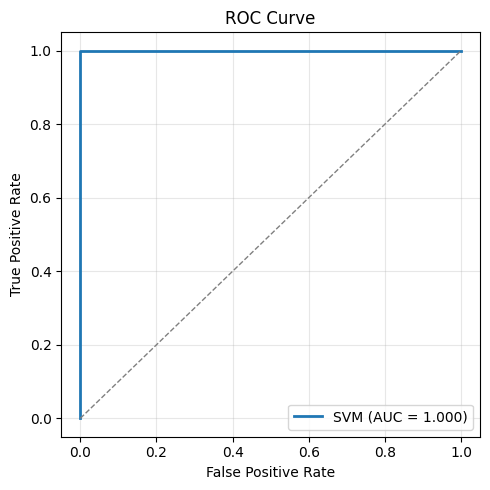

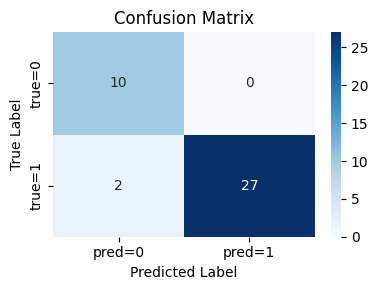

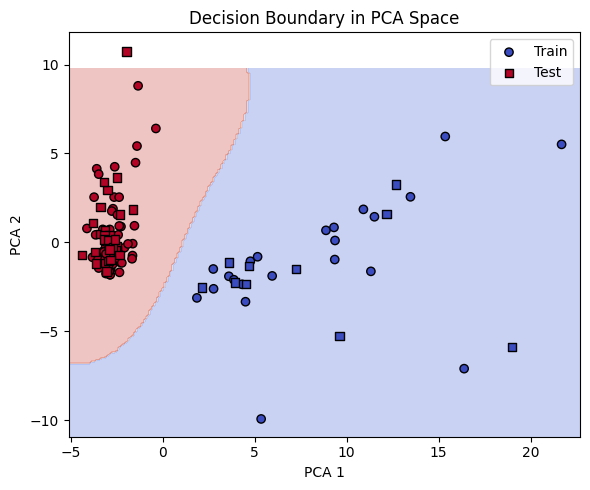


Results: {'accuracy': 0.9487179487179487, 'auc': np.float64(1.0), 'confusion_matrix': array([[10,  0],
       [ 2, 27]])}


In [ ]:
if X_expr is not None and y is not None:
    results = train_evaluate_svm_classifier(
        X_expr,
        y,
        test_size=0.3,
        random_state=42,
        kernel="rbf",
        C=1.0,
        plot_boundary=True
    )
    print("\nResults:", results)

## SVM using gene subtypes

In [ ]:
X_cancer = cancer_tpm.T

# transpose the normal TPM
X_normal = normal_tpm.T

# combine exp matrix
gene_expr = pd.concat([X_cancer, X_normal], axis=0)

# creating label vector
y_cancer = np.ones(X_cancer.shape[0], dtype=int)
y_normal = np.zeros(X_normal.shape[0], dtype=int)
y = np.concatenate([y_cancer, y_normal])


In [ ]:
print(gene_expr.shape)

(128, 60675)


In [ ]:
def run_svm_on_subtype_with_boundary( gene_list_or_path, gene_expr_df, y, subtype_name, test_size=0.3,random_state=42,plot_boundary=True):

    # Load gene list
    if isinstance(gene_list_or_path, str) and gene_list_or_path.endswith(".txt"):
        # read first column as gene IDs
        df_genes = pd.read_csv(gene_list_or_path, sep="\t", header=0, usecols=[0], names=["gene_id"])
        genes = df_genes["gene_id"].dropna().astype(str).tolist()
    else:
        genes = gene_list_or_path

    # Keep only genes present in gene_expr_df columns
    genes_in_expr = [g for g in genes if g in gene_expr_df.columns]
    if len(genes_in_expr) < 5: # approx value
        print(f"[{subtype_name}] Too few genes found in expression matrix: {len(genes_in_expr)}")
        return None

    X_sub = gene_expr_df[genes_in_expr].values
    print(f"[{subtype_name}] Using {len(genes_in_expr)} genes.")

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_sub, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # Standard Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Training SVM
    svm_clf = SVC(kernel="linear", C=1.0, probability=True, class_weight="balanced", random_state=random_state)
    svm_clf.fit(X_train_scaled, y_train)

    # y pred
    y_pred = svm_clf.predict(X_test_scaled)
    y_proba = svm_clf.predict_proba(X_test_scaled)[:, 1]

    # auc, confusion matrix
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Accuracy = {acc:.4f}\n")
    print(f"AUC = {auc:.4f}\n")
    print(f"Confusion Matrix:\n{cm}\n")

    # ROC AUC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], "--", color="gray", lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{subtype_name} ROC-AUC")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # confusion matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["pred=0", "pred=1"],
        yticklabels=["true=0", "true=1"]
    )
    plt.title(f"{subtype_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    results = {
        "subtype": subtype_name,
        "accuracy": acc,
        "auc": auc,
        "confusion_matrix": cm,
        "n_genes": len(genes_in_expr)
    }


    # Plot decision boundary
    if plot_boundary:
        pca = PCA(n_components=2, random_state=random_state)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)

        # Train a fresh SVM on 2D PCA features - ONLY FOR VISUALIZATION!
        svm_2d = SVC(kernel="linear", C=1.0, class_weight="balanced", probability=True, random_state=random_state)
        svm_2d.fit(X_train_pca, y_train)
        x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
        y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, 200),
            np.linspace(y_min, y_max, 200)
        )
        grid = np.c_[xx.ravel(), yy.ravel()]
        Z = svm_2d.predict(grid).reshape(xx.shape)

        plt.figure(figsize=(6, 5))
        plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
        plt.scatter(
            X_train_pca[:, 0], X_train_pca[:, 1],
            c=y_train, cmap="coolwarm", edgecolor="k", label="Train Samples"
        )
        plt.scatter(
            X_test_pca[:, 0], X_test_pca[:, 1],
            c=y_test, cmap="coolwarm", marker="s", edgecolor="k", label="Test Samples"
        )
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.title(f"{subtype_name} Decision Boundary (2D PCA)")
        plt.legend(loc="upper right")
        plt.tight_layout()
        plt.show()

    return results


In [ ]:
def load_gene_list(path):
    df = pd.read_csv(path, sep="\t", header=0, usecols=[0], names=["gene_id"])
    # Drop any empty rows:
    return df["gene_id"].dropna().astype(str).tolist()


miRNA_genes      = load_gene_list(f"{filepath}/Data/miRNA_genes.txt") # We are using Genes that were actually measured and had nonzero expression, and were kept during preprocessing  (DESeq2 filtering); Paper uses ALL
scaRNA_genes     = load_gene_list(f"{filepath}/Data/scaRNA_genes.txt")
protein_genes    = load_gene_list(f"{filepath}/Data/protein_coding_genes.txt")

In [ ]:
print(f"miRNA genes: {len(miRNA_genes)}")
print(f"scaRNA genes: {len(scaRNA_genes)}")
print(f"protein genes: {len(protein_genes)}")

miRNA genes: 1945
scaRNA genes: 51
protein genes: 23262


[miRNA] Using 1447 genes.
Accuracy = 0.8205

AUC = 0.8172

Confusion Matrix:
[[ 5  5]
 [ 2 27]]



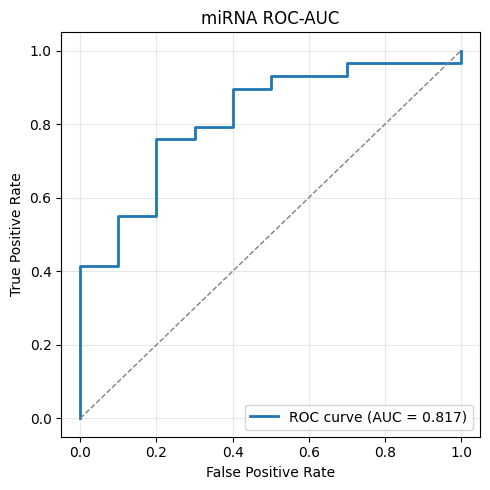

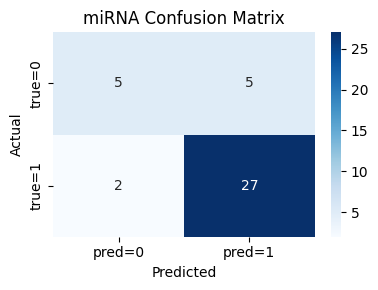

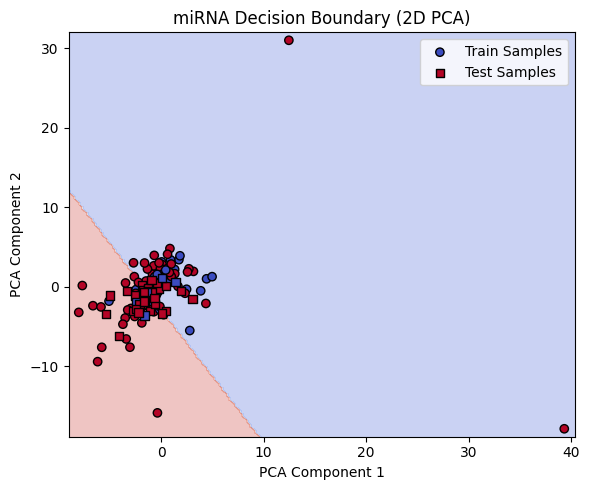

[scaRNA] Using 49 genes.
Accuracy = 0.6154

AUC = 0.5276

Confusion Matrix:
[[ 3  7]
 [ 8 21]]



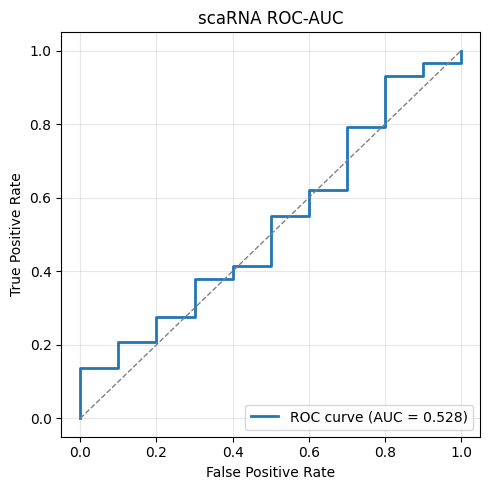

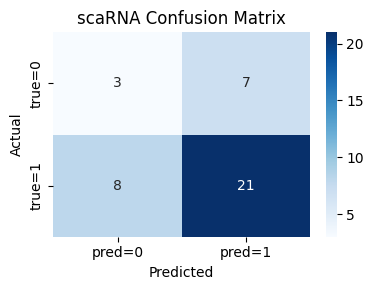

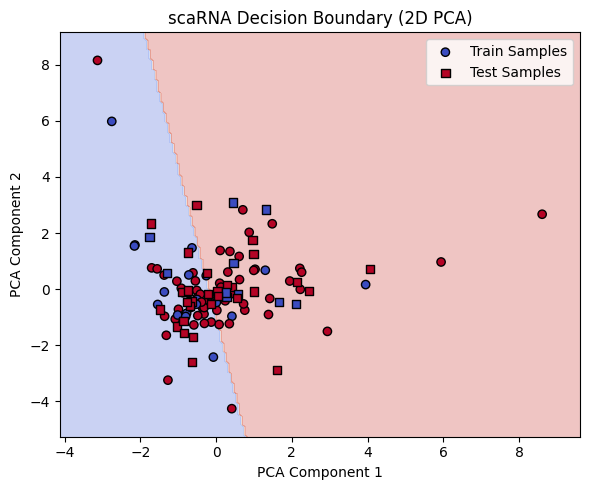

[protein_coding] Using 19625 genes.
Accuracy = 0.8974

AUC = 0.9897

Confusion Matrix:
[[ 7  3]
 [ 1 28]]



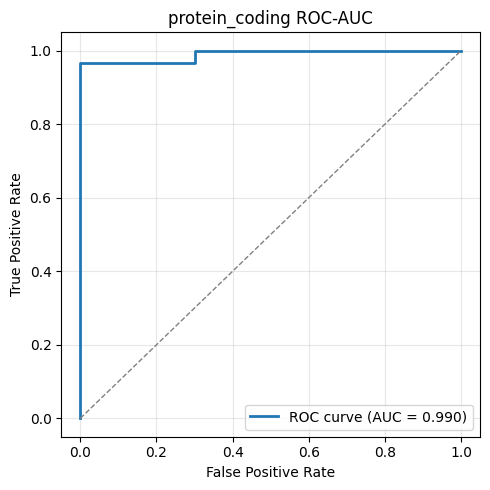

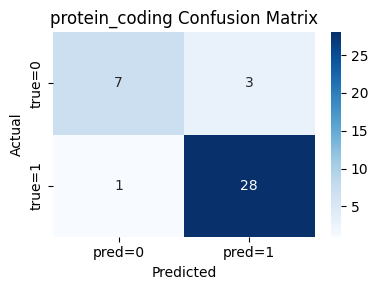

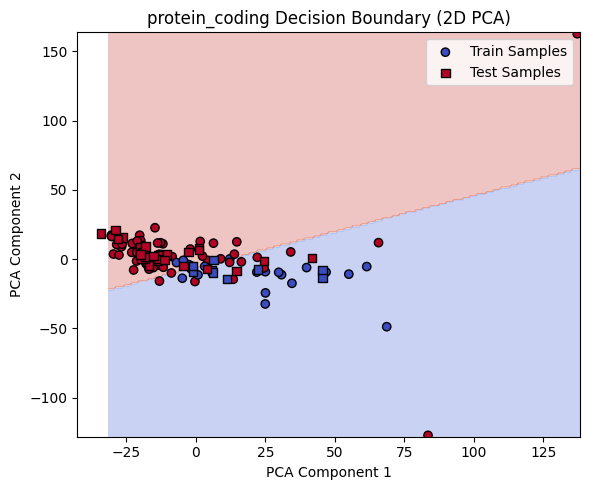

          subtype  n_genes  accuracy       auc
2  protein_coding    19625  0.897436  0.989655
0           miRNA     1447  0.820513  0.817241
1          scaRNA       49  0.615385  0.527586


In [ ]:
gene_expr.columns = gene_expr.columns.astype(str)
results = []
for subtype_name, gene_list in [
    ("miRNA", miRNA_genes),
    ("scaRNA", scaRNA_genes),
    ("protein_coding", protein_genes),
]:
    res = run_svm_on_subtype_with_boundary(
        gene_list,
        gene_expr,
        y,
        subtype_name
    )
    if res:
        results.append(res)


results_df = pd.DataFrame(results).sort_values("auc", ascending=False)
print(results_df[["subtype", "n_genes", "accuracy", "auc"]])

[miRNA] Using 1447 genes.
Accuracy = 0.8205

AUC = 0.8172

Confusion Matrix:
[[ 5  5]
 [ 2 27]]



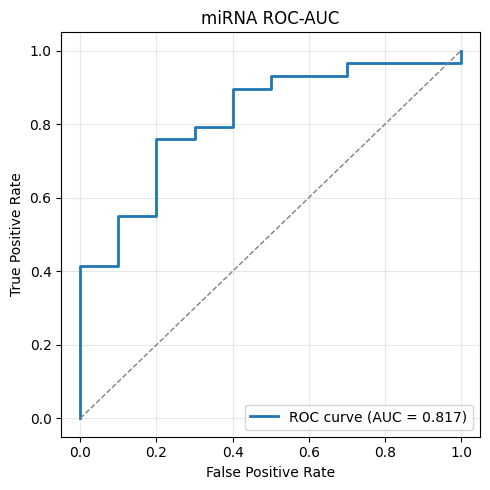

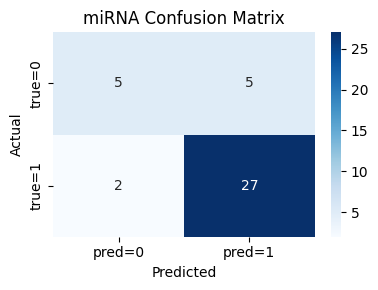

[scaRNA] Using 49 genes.
Accuracy = 0.6154

AUC = 0.5276

Confusion Matrix:
[[ 3  7]
 [ 8 21]]



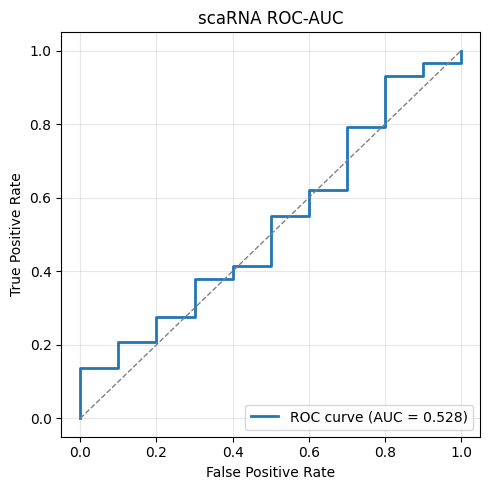

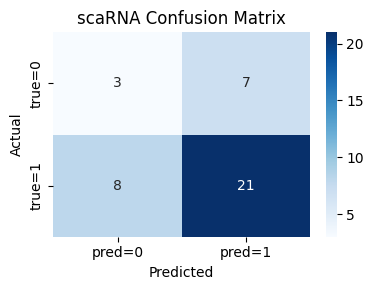

[protein_coding] Using 19625 genes.
Accuracy = 0.8974

AUC = 0.9897

Confusion Matrix:
[[ 7  3]
 [ 1 28]]



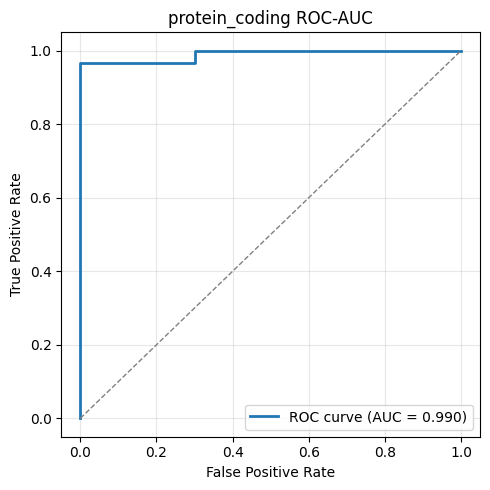

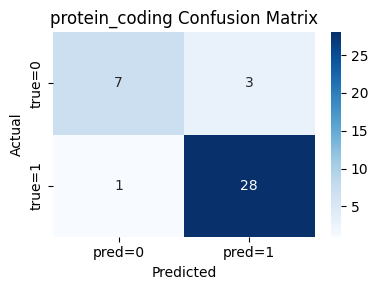

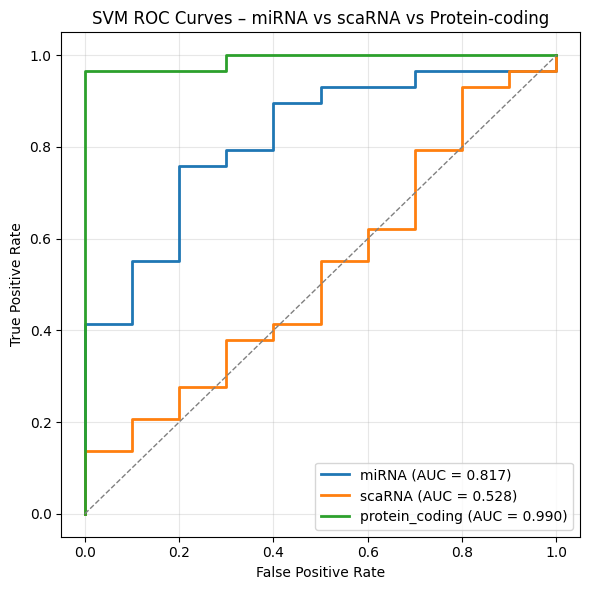

In [ ]:
roc_data = []

for subtype_name, gene_list in [
    ("miRNA", miRNA_genes),
    ("scaRNA", scaRNA_genes),
    ("protein_coding", protein_genes),
]:
    res = run_svm_on_subtype_with_boundary(gene_list, gene_expr, y, subtype_name, plot_boundary=False)
    if res is None:
        continue


    genes_in_expr   = [g for g in gene_list if g in gene_expr.columns]
    X_sub           = gene_expr[genes_in_expr].values
    X_train, X_test, y_train, y_test = train_test_split(
        X_sub, y, test_size=0.3, stratify=y, random_state=42
    )
    scaler  = StandardScaler()
    Xt_scaled = scaler.fit_transform(X_train)
    Xv_scaled = scaler.transform(X_test)

    clf = SVC(kernel="linear", C=1.0, probability=True, class_weight="balanced", random_state=42)
    clf.fit(Xt_scaled, y_train)
    y_prob = clf.predict_proba(Xv_scaled)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_val     = roc_auc_score(y_test, y_prob)
    roc_data.append((subtype_name, fpr, tpr, auc_val))


plt.figure(figsize=(6, 6))
for subtype, fpr, tpr, auc_val in roc_data:
    plt.plot(fpr, tpr, lw=2, label=f"{subtype} (AUC = {auc_val:.3f})")

plt.plot([0, 1], [0, 1], "--", color="gray", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM ROC Curves – miRNA vs scaRNA vs Protein-coding")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## K-fold cross validation

Did not end up being useful :(

In [ ]:
def stratkfold(X, y, n_splits= 10, C= 1.0,kernel= "linear", class_weight="balanced",random_state= 42, plot= True):
  # penalty param of SVM - C

    X_arr = X.values if hasattr(X, "values") else np.asarray(X)
    y_arr = np.asarray(y)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    mean_fpr = np.linspace(0, 1, 100)

    fold_accuracies = []
    fold_aucs = []
    fold_confmats = []
    tprs = []
    aucs = []

    if plot:
        plt.figure(figsize=(6, 6))

    for fold_idx, (train_idx, valid_idx) in enumerate(skf.split(X_arr, y_arr), start=1):
        # train test split
        X_train, X_valid = X_arr[train_idx], X_arr[valid_idx]
        y_train, y_valid = y_arr[train_idx], y_arr[valid_idx]

        # standard scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_valid_scaled = scaler.transform(X_valid)

        # training linear svm
        svm_clf = SVC(
            kernel=kernel,
            C=C,
            probability=True,
            class_weight=class_weight,
            random_state=random_state
        )
        svm_clf.fit(X_train_scaled, y_train)

        # y pred
        y_pred = svm_clf.predict(X_valid_scaled)
        y_proba_pos = svm_clf.predict_proba(X_valid_scaled)[:, 1]

        # auc, confusion matrix
        acc_fold = accuracy_score(y_valid, y_pred)
        auc_fold = roc_auc_score(y_valid, y_proba_pos)
        cm_fold = confusion_matrix(y_valid, y_pred)

        fold_accuracies.append(acc_fold)
        fold_aucs.append(auc_fold)
        fold_confmats.append(cm_fold)

        if plot:
            print(f"Fold {fold_idx}: Accuracy = {acc_fold:.3f}, AUC = {auc_fold:.3f}")
            print("Confusion Matrix:\n", cm_fold, "\n")

            # ROC curve for this fold
            fpr, tpr, _ = roc_curve(y_valid, y_proba_pos)
            plt.plot(
                fpr,
                tpr,
                linewidth=1.5,
                alpha=0.6,
                label=f"Fold {fold_idx} (AUC = {auc_fold:.3f})"
            )
            # Interpolate for mean ROC later
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(auc_fold)

    mean_acc = np.mean(fold_accuracies)
    std_acc = np.std(fold_accuracies)
    mean_auc = np.mean(fold_aucs)
    std_auc = np.std(fold_aucs)
    sum_cm = np.sum(fold_confmats, axis=0)

    if plot:

        plt.plot(
            [0, 1], [0, 1],
            linestyle="--",
            color="gray",
            linewidth=1,
            label="Chance (AUC = 0.5)"
        )

        plt.xlabel("False Positive Rate", fontsize=12)
        plt.ylabel("True Positive Rate", fontsize=12)
        plt.title(f"ROC Curves (Stratified {n_splits}-Fold CV)", fontsize=14)
        plt.legend(loc="lower right", fontsize="small", frameon=True)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()


        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        std_tpr = np.std(tprs, axis=0)

        plt.figure(figsize=(6, 6))
        plt.plot(
            mean_fpr,
            mean_tpr,
            color="b",
            linewidth=2,
            label=f"Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})"
        )
        plt.fill_between(
            mean_fpr,
            np.maximum(mean_tpr - std_tpr, 0),
            np.minimum(mean_tpr + std_tpr, 1),
            color="blue",
            alpha=0.2,
            label="± 1 Std. Dev"
        )
        plt.plot(
            [0, 1], [0, 1],
            linestyle="--",
            color="gray",
            linewidth=1
        )
        plt.xlabel("False Positive Rate", fontsize=12)
        plt.ylabel("True Positive Rate", fontsize=12)
        plt.title(f"Mean ROC Curve (Stratified {n_splits}-Fold CV)", fontsize=14)
        plt.legend(loc="lower right", fontsize="small", frameon=True)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    return {
        "mean_accuracy": mean_acc,
        "std_accuracy": std_acc,
        "mean_auc": mean_auc,
        "std_auc": std_auc,
        "confusion_matrix_sum": sum_cm
    }


Fold 1: Accuracy = 0.923, AUC = 1.000
Confusion Matrix:
 [[ 6  0]
 [ 2 18]] 

Fold 2: Accuracy = 0.962, AUC = 1.000
Confusion Matrix:
 [[ 7  0]
 [ 1 18]] 

Fold 3: Accuracy = 0.962, AUC = 1.000
Confusion Matrix:
 [[ 7  0]
 [ 1 18]] 

Fold 4: Accuracy = 0.960, AUC = 1.000
Confusion Matrix:
 [[ 6  0]
 [ 1 18]] 

Fold 5: Accuracy = 1.000, AUC = 1.000
Confusion Matrix:
 [[ 6  0]
 [ 0 19]] 



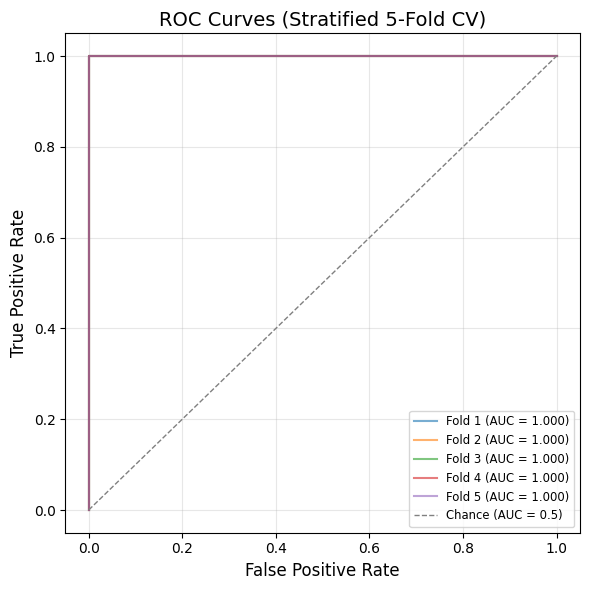

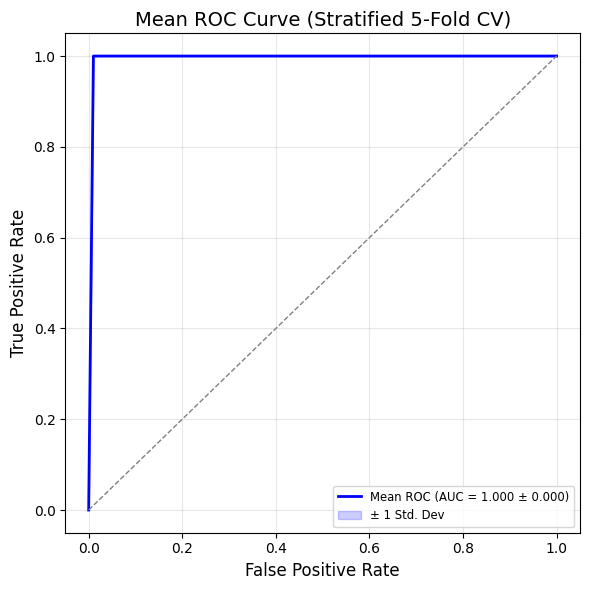

Mean Accuracy: 0.9612307692307691 ± 0.024332995593560038
Mean AUC: 1.0 ± 0.0
Summed Confusion Matrix:
 [[32  0]
 [ 5 91]]


In [ ]:
results = stratkfold(
    X_expr,
    y,
    n_splits=5,
    C=1.0,
    kernel="rbf",
    class_weight="balanced",
    random_state=42,
    plot=True
)

print("Mean Accuracy:", results["mean_accuracy"], "±", results["std_accuracy"])
print("Mean AUC:", results["mean_auc"], "±", results["std_auc"])
print("Summed Confusion Matrix:\n", results["confusion_matrix_sum"])

## Random Forest (for subtypes)

In [ ]:
def run_rf_on_subtype(
    gene_list,
    gene_expr_df,
    y,
    subtype_name,
    test_size=0.3,
    random_state=42
):
    genes_in_expr = [g for g in gene_list if g in gene_expr_df.columns]
    if len(genes_in_expr) < 5:
        print(f"[{subtype_name}] Too few genes found in expression matrix for Random Forest: {len(genes_in_expr)}")
        return None

    X_sub = gene_expr_df[genes_in_expr].values
    X_train, X_test, y_train, y_test = train_test_split(
        X_sub, y, test_size=test_size, stratify=y, random_state=random_state
    )

    rf_clf = RandomForestClassifier(n_estimators=100, max_depth=None,
                                    class_weight="balanced", random_state=random_state)
    rf_clf.fit(X_train, y_train)

    y_pred = rf_clf.predict(X_test)
    y_proba = rf_clf.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

     # AUC-ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr,
             lw=2,
             label=f"Random Forest (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1],
             linestyle="--",
             color="gray",
             lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{subtype_name} – ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"[{subtype_name}] Random Forest")
    print(f"Accuracy = {acc:.4f}, AUC = {auc:.4f}")
    print(f"Confusion Matrix:\n{cm}\n")

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
                xticklabels=["pred=0", "pred=1"], yticklabels=["true=0", "true=1"])
    plt.title(f"{subtype_name} - Random Forest Confusion Matrix")
    plt.tight_layout()
    plt.show()


    return {
        "subtype": subtype_name,
        "model": "rf",
        "accuracy": acc,
        "auc": auc,
        "confusion_matrix": cm,
        "n_genes": len(genes_in_expr)
    }

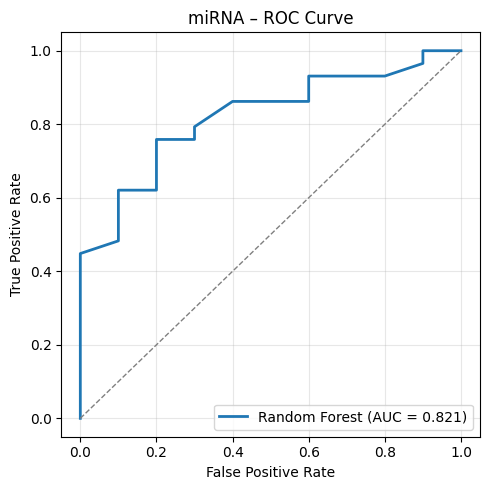

[miRNA] Random Forest
Accuracy = 0.7436, AUC = 0.8207
Confusion Matrix:
[[ 0 10]
 [ 0 29]]



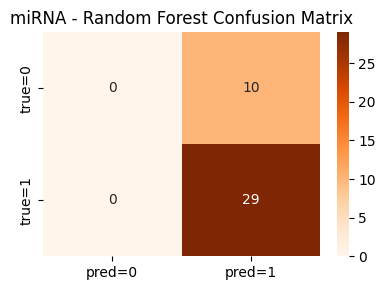

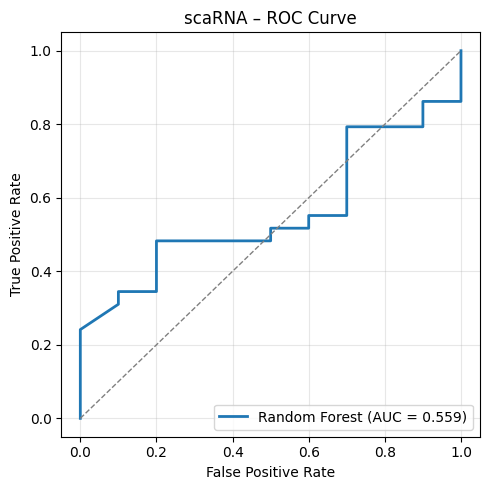

[scaRNA] Random Forest
Accuracy = 0.6410, AUC = 0.5586
Confusion Matrix:
[[ 1  9]
 [ 5 24]]



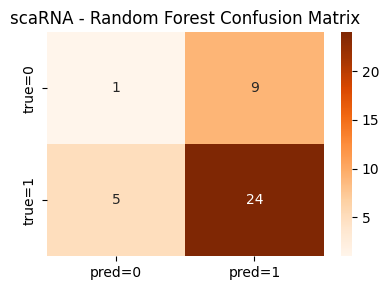

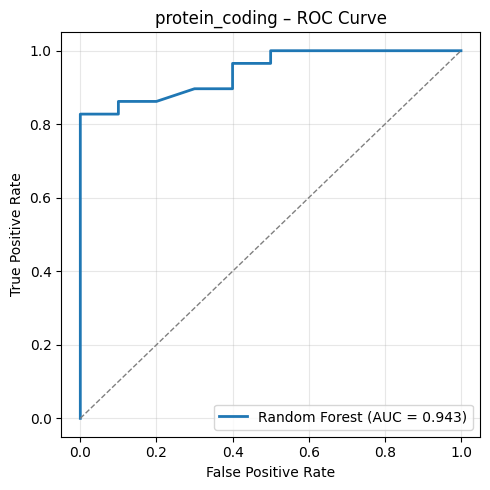

[protein_coding] Random Forest
Accuracy = 0.8462, AUC = 0.9431
Confusion Matrix:
[[ 4  6]
 [ 0 29]]



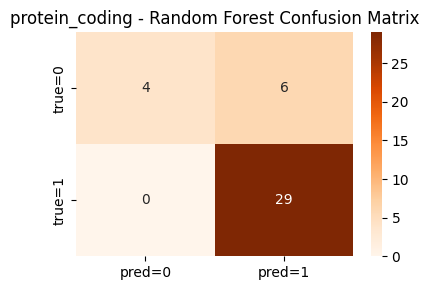

          subtype  n_genes  accuracy       auc
2  protein_coding    19625  0.846154  0.943103
0           miRNA     1447  0.743590  0.820690
1          scaRNA       49  0.641026  0.558621


In [ ]:
gene_expr.columns = gene_expr.columns.astype(str)
results = []
for subtype_name, gene_list in [
    ("miRNA", miRNA_genes),
    ("scaRNA", scaRNA_genes),
    ("protein_coding", protein_genes),
]:
    res = run_rf_on_subtype(
        gene_list,
        gene_expr,
        y,
        subtype_name
    )
    if res:
        results.append(res)

# results
results_df = pd.DataFrame(results).sort_values("auc", ascending=False)
print(results_df[["subtype", "n_genes", "accuracy", "auc"]])

miRNA            Acc = 0.744  AUC = 0.821  genes = 1447
scaRNA           Acc = 0.641  AUC = 0.559  genes = 49
protein_coding   Acc = 0.846  AUC = 0.943  genes = 19625


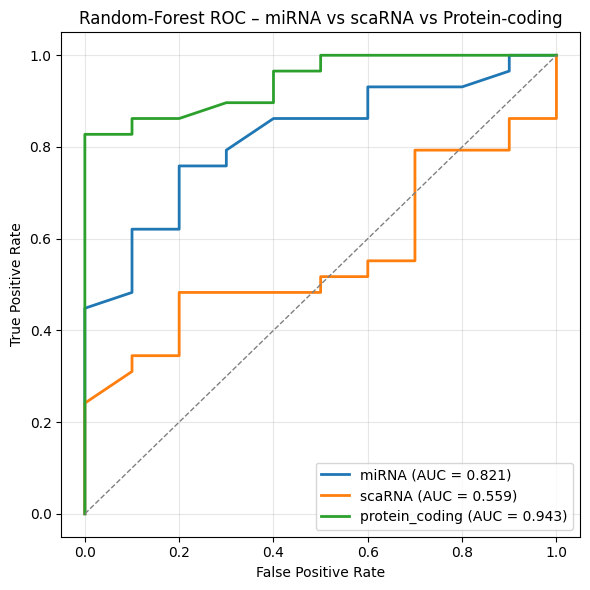

In [ ]:
# combined ROC curve
roc_curves = []

for subtype_name, gene_list in [
    ("miRNA", miRNA_genes),
    ("scaRNA", scaRNA_genes),
    ("protein_coding", protein_genes),
]:
    genes_in_expr = [g for g in gene_list if g in gene_expr.columns]
    if len(genes_in_expr) < 5:
        print(f"[{subtype_name}] overlap <5 genes – skipped.")
        continue

    X = gene_expr[genes_in_expr].values
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        class_weight="balanced",
        random_state=42
    )
    rf.fit(X_tr, y_tr)

    y_prob = rf.predict_proba(X_te)[:, 1]
    y_pred = rf.predict(X_te)

    acc  = accuracy_score(y_te, y_pred)
    auc  = roc_auc_score(y_te, y_prob)
    fpr, tpr, _ = roc_curve(y_te, y_prob)

    roc_curves.append((subtype_name, fpr, tpr, auc, acc))
    print(f"{subtype_name:15s}  Acc = {acc:.3f}  AUC = {auc:.3f}  genes = {len(genes_in_expr)}")

plt.figure(figsize=(6, 6))
for subtype, fpr, tpr, auc, _ in roc_curves:
    plt.plot(fpr, tpr, lw=2, label=f"{subtype} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], "--", color="gray", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random-Forest ROC – miRNA vs scaRNA vs Protein-coding")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()

## MLP

In [ ]:

def run_mlp_on_subtype(
    gene_list_or_path,
    gene_expr_df,
    y,
    subtype_name,
    test_size=0.3,
    random_state=None,
    hidden_layers =(128, 64),
    alpha=1e-4,           # L2 penalty
    dropout=False,        # if True use alpha plus early-stopping; sklearn MLP has no  dropout
    max_iter=400,
):

    if isinstance(gene_list_or_path, str) and gene_list_or_path.endswith(".txt"):
        sub_df = pd.read_csv(gene_list_or_path, sep="\t", header=0, usecols=[0], names=["gene_id"])
        genes = sub_df["gene_id"].dropna().astype(str).tolist()
    else:
        genes = gene_list_or_path

    genes_in_expr = [g for g in genes if g in gene_expr_df.columns]
    if len(genes_in_expr) < 5:
        print(f"[{subtype_name}] Too few genes present ({len(genes_in_expr)}); skipping.")
        return None

    X_sub = gene_expr_df[genes_in_expr].values

    # 2) train/test split
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_sub, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # standard scaler
    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr)
    X_te_s = scaler.transform(X_te)

    # build and fit on MLP
    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layers,
        activation="relu",
        solver="adam",
        alpha=alpha,
        batch_size="auto",
        learning_rate="adaptive",
        max_iter=max_iter,       # uses 10 % of training set for validation
        n_iter_no_change=15,
        random_state=random_state,
        verbose=False
    )
    mlp.fit(X_tr_s, y_tr)
    # early_stopping=True,


    # y pred
    y_pred  = mlp.predict(X_te_s)
    y_prob  = mlp.predict_proba(X_te_s)[:, 1]

    acc = accuracy_score(y_te, y_pred)
    auc = roc_auc_score(y_te, y_prob)
    cm  = confusion_matrix(y_te, y_pred)

    print(f"[{subtype_name}] MLP")
    print(f"Accuracy = {acc:.4f},  AUC = {auc:.4f}")
    print("Confusion matrix:\n", cm, "\n")

    # auc roc curve
    fpr, tpr, _ = roc_curve(y_te, y_prob)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, lw=2, label=f"MLP (AUC = {auc:.3f})")
    plt.plot([0,1],[0,1],"--",color="gray")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"{subtype_name} – ROC curve (MLP)")
    plt.legend(loc="lower right"); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    # confusion matrix
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
                xticklabels=["pred 0","pred 1"], yticklabels=["true 0","true 1"])
    plt.title(f"{subtype_name} – Confusion matrix (MLP)")
    plt.tight_layout(); plt.show()

    return {
        "subtype":        subtype_name,
        "model":          "mlp",
        "n_genes":        len(genes_in_expr),
        "accuracy":       acc,
        "auc":            auc,
        "confusion_mat":  cm
    }

On 3 human gene subtypes

[miRNA] MLP
Accuracy = 0.7179,  AUC = 0.5241
Confusion matrix:
 [[ 0 10]
 [ 1 28]] 



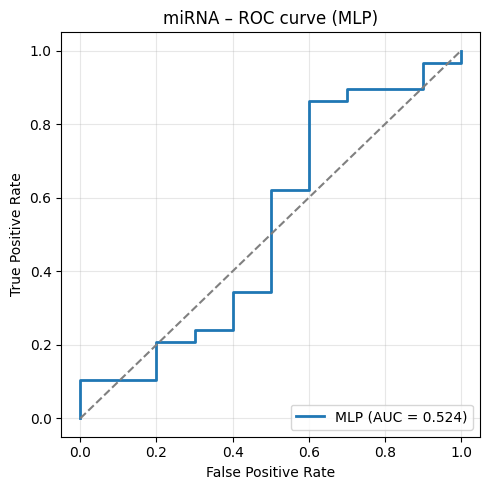

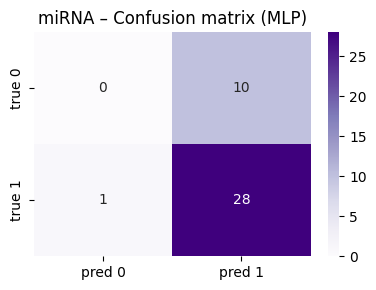

[scaRNA] MLP
Accuracy = 0.7179,  AUC = 0.6103
Confusion matrix:
 [[ 3  7]
 [ 4 25]] 



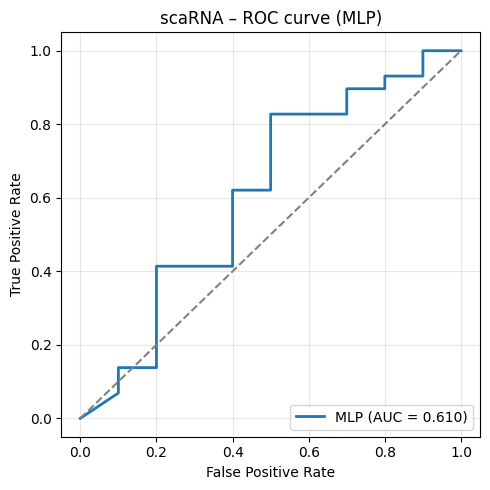

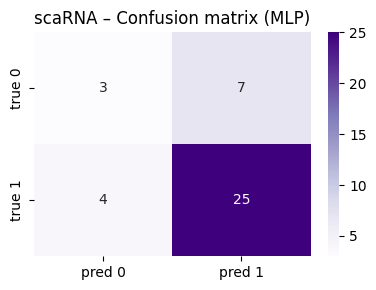

[protein_coding] MLP
Accuracy = 0.9744,  AUC = 0.9966
Confusion matrix:
 [[ 9  1]
 [ 0 29]] 



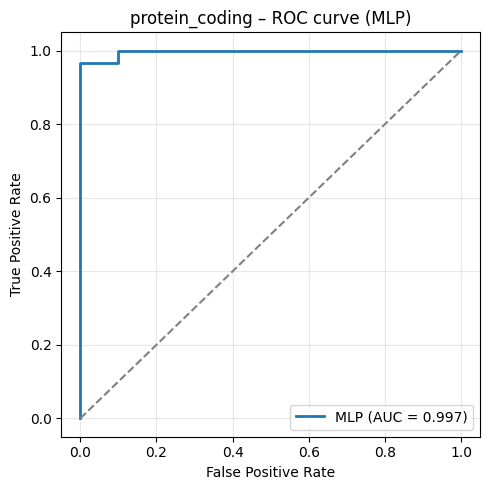

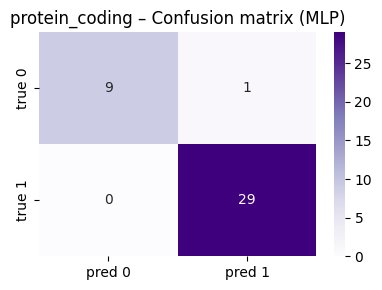

,subtype,n_genes,accuracy,auc
0,miRNA,1447,0.717949,0.524138
1,scaRNA,49,0.717949,0.610345
2,protein_coding,19625,0.974359,0.996552


In [ ]:
mlp_results = []
for subtype_name, gene_list in [
    ("miRNA", miRNA_genes),
    ("scaRNA", scaRNA_genes),
    ("protein_coding", protein_genes)
]:
    res = run_mlp_on_subtype(
        gene_list,
        gene_expr,
        y,
        subtype_name,
        hidden_layers=(128, 64),      # 2 hidden layers
        alpha=1e-4,                   # L2 regularisation
        max_iter=400
    )
    if res:
        mlp_results.append(res)

pd.DataFrame(mlp_results)[["subtype", "n_genes", "accuracy", "auc"]]


miRNA            Acc = 0.744  AUC = 0.534  genes = 1447
scaRNA           Acc = 0.718  AUC = 0.576  genes = 49
protein_coding   Acc = 0.923  AUC = 1.000  genes = 19625


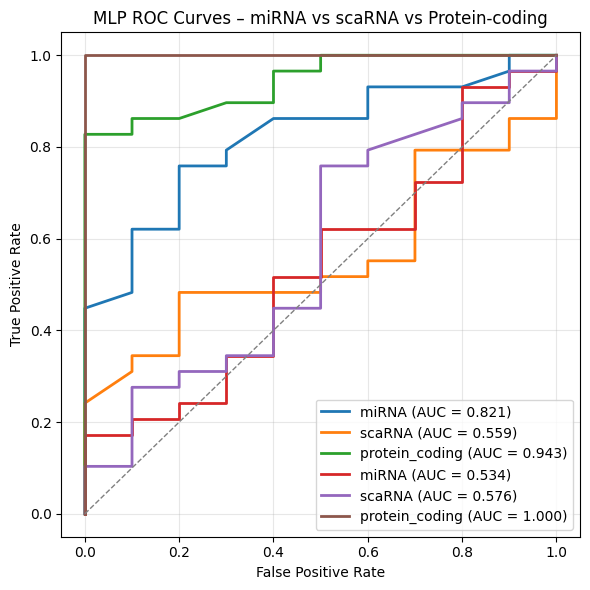

In [ ]:
# combined plot
oc_curves = []

for subtype_name, gene_list in [
    ("miRNA", miRNA_genes),
    ("scaRNA", scaRNA_genes),
    ("protein_coding", protein_genes),
]:

    genes_present = [g.upper() for g in gene_list if g.upper() in gene_expr.columns]
    if len(genes_present) < 5:
        print(f"[{subtype_name}] overlap < 5 genes – skipped.")
        continue

    X = gene_expr[genes_present].values
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.30, stratify=y, random_state=None
    )

    scaler  = StandardScaler()
    X_tr_s  = scaler.fit_transform(X_tr)
    X_te_s  = scaler.transform(X_te)

    mlp = MLPClassifier(
        hidden_layer_sizes = (128, 64),
        alpha              = 1e-4,
        activation         = "relu",
        solver             = "adam",
        learning_rate      = "adaptive",
        max_iter           = 400,
        early_stopping     = False,
        random_state       = None
    )
    mlp.fit(X_tr_s, y_tr)

    y_prob = mlp.predict_proba(X_te_s)[:, 1]
    y_pred = mlp.predict(X_te_s)

    acc = accuracy_score(y_te, y_pred)
    auc = roc_auc_score(y_te, y_prob)
    fpr, tpr, _ = roc_curve(y_te, y_prob)

    roc_curves.append((subtype_name, fpr, tpr, auc, acc))
    print(f"{subtype_name:15s}  Acc = {acc:.3f}  AUC = {auc:.3f}  genes = {len(genes_present)}")

plt.figure(figsize=(6, 6))
for subtype, fpr, tpr, auc, _ in roc_curves:
    plt.plot(fpr, tpr, lw=2, label=f"{subtype} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], "--", color="gray", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("MLP ROC Curves – miRNA vs scaRNA vs Protein-coding")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Genes from known BC Panels

In [ ]:
gene_panel_path = f"{filepath}/Data/Gene_Panels/feature_set_gene_panels.csv"
gene_panel_df   = pd.read_csv(gene_panel_path)

panel_genes = gene_panel_df.iloc[:, 0].dropna().astype(str).tolist()

In [ ]:
# normalising
panel_genes = [g.split('.')[0].upper() for g in panel_genes]
gene_expr.columns = gene_expr.columns.str.upper()

[BC_gene_panel] MLP
Accuracy = 0.8974,  AUC = 0.9276
Confusion matrix:
 [[ 6  4]
 [ 0 29]] 



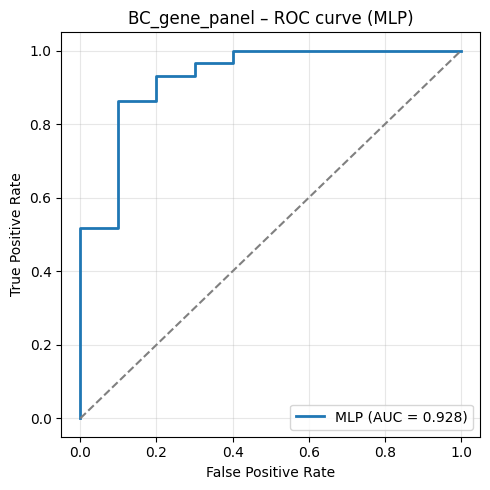

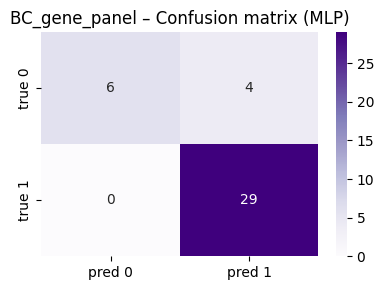


Results for 184-gene panel:
subtype: BC_gene_panel
model: mlp
n_genes: 184
accuracy: 0.8974358974358975
auc: 0.9275862068965517


In [ ]:
gene_panel_results = run_mlp_on_subtype(
    gene_list_or_path = panel_genes,
    gene_expr_df      = gene_expr,
    y                 = y,
    subtype_name      = "BC_gene_panel",
    hidden_layers     = (128, 64),
    alpha             = 1e-4,
    max_iter          = 400,
    random_state      = 42
)

print("\nResults for 184-gene panel:")
for k, v in gene_panel_results.items():
    if k not in {"confusion_mat"}:
        print(f"{k}: {v}")

Regulons

In [ ]:
tf_path      = f"{filepath}Data/TF-Decoupler-RegulatedGenes/List_of_Transcription_Factors.csv"        # 38 TFs
targets_path = f"{filepath}Data/TF-Decoupler-RegulatedGenes/Regulated Genes - TF to Decoupler.csv"    # 2534 targets

tf_df = pd.read_csv(tf_path,header=0, usecols=[0], names=["gene_id"],encoding="latin1")
targets_df = pd.read_csv(targets_path, header=0, usecols=[0], names=["gene_id"])

tf_genes      = tf_df["gene_id"].dropna().astype(str).tolist()
target_genes  = targets_df["gene_id"].dropna().astype(str).tolist()

In [ ]:
regulon_without_tf = target_genes
regulon_raw = tf_genes + target_genes
print("Regulons with TF:", len(regulon_raw))
print("Regulons without TF:", len(regulon_without_tf))

Regulons with TF: 2571
Regulons without TF: 2534


In [ ]:
# Normalizing
regulon_ids = [g.split(".")[0].upper() for g in regulon_raw]
regulon_tf = [g.split(".")[0].upper() for g in regulon_without_tf]


gene_expr.columns = gene_expr.columns.str.split(".").str[0].str.upper()

In [ ]:
print(gene_expr)

     ENSG00000000003  ENSG00000000005  ...  ENSG00000283123  ENSG00000283125
C1          7.071605        13.279391  ...         0.000000        19.542796
C2         60.610797        47.424080  ...         0.000000         0.000000
C3         58.255903        60.455497  ...         0.000000         0.000000
C4         29.917356         6.482332  ...         0.000000         0.000000
C5         24.500322        53.675826  ...         0.000000        45.138720
..               ...              ...  ...              ...              ...
N28        20.452887        64.812467  ...        47.910042         0.000000
N29        16.581454        52.544413  ...         0.000000         0.000000
N30         9.340377         0.000000  ...         0.000000         0.000000
N31         5.074037       100.046777  ...        23.771445         0.000000
N32         4.109799        11.576360  ...         0.000000        17.036508

[128 rows x 60675 columns]


In [ ]:
print(regulon_ids[:10])
print(regulon_tf[:10])

['Ä ¦\x92:©\tÎIVVÎ«ÊEÒ@\x08\x9a{Ä¸\x9f&ÂÊÁ\x03\x9a\x03ÃÓÞM×\x84¶5', '÷A\x9d\x1cÚ8!\x84\x16BÚ\x05÷FÀ¬©\x07®Q=PÜ\x01Æ\x7f\x823\x8a\x02\x876\x96*¸Ë)ÙHBÝ<\t8Þ\x1aÕÝÈR¾ÊÕ_ÈÝ\x14Ç\x01\x1dOÃ', 'V', 'ÎL\x185#ÚAÉ\x0fK]\x04\x9f', 'K>\x0f{\x8b\x11Ô9B\x8d\x11Ü9Â\x0e#"A\x8e¤9)X)8RÌ±7Ç\x1f\x11Ý°\x13A\x0e#¦Â\x1cFÌ\x84¹CDT\x161\x17ÆX\x9a\x93\x82\x95\x82CÅ\\ÄÍE0±\x850\x87\x11Ò\x1cFHSÑ\x97Æ"IN', 'V', '', 'V', 'N¦¸\x9b{WST\'®V·\x18"ÝA\x84T7ŸÒÝ\\º\x93\x82\x95\x82\x9b+Î\x16ÞÝ\x02Ý\x89+ÕM D\\U×\x18"Í-À\x9e\x11=Ú¾\x90Þ¤`¥À\x16\x8a?3Î·ÙÑ×W\x16\x1fS*¼\x0eDIG\x1f!ŸH\t', "O@±\xa0¸SÅ³\xad3Z8ÎÔ\x93ÓÑGÒ\x96Ä\x83ΜWÞÁ\x96¹À\x16\x92\t¢\t²\x89\x06'¦§\x13CØIÍ¥-\t\x06Ë@\x16Ø¢\x0bL\x01\x93\x80BAQÇÊG[=\x97\x18\x84"]
['A2M', 'AATF', 'ABCA1', 'ABCA3', 'ABCA4', 'ABCB1', 'ABCB11', 'ABCB6', 'ABCC1', 'ABCC2']


In [ ]:
overlap = set(regulon_ids) & set(gene_expr.columns)
missing = sorted(set(regulon_ids) - overlap)

print("Overlap size  :", len(overlap))
print("Missing genes :", len(missing))

Overlap size  : 0
Missing genes : 2568


In [ ]:
print(gene_expr)

     ENSG00000000003  ENSG00000000005  ...  ENSG00000283123  ENSG00000283125
C1          7.071605        13.279391  ...         0.000000        19.542796
C2         60.610797        47.424080  ...         0.000000         0.000000
C3         58.255903        60.455497  ...         0.000000         0.000000
C4         29.917356         6.482332  ...         0.000000         0.000000
C5         24.500322        53.675826  ...         0.000000        45.138720
..               ...              ...  ...              ...              ...
N28        20.452887        64.812467  ...        47.910042         0.000000
N29        16.581454        52.544413  ...         0.000000         0.000000
N30         9.340377         0.000000  ...         0.000000         0.000000
N31         5.074037       100.046777  ...        23.771445         0.000000
N32         4.109799        11.576360  ...         0.000000        17.036508

[128 rows x 60675 columns]


In [ ]:
for g in missing:
    gene_expr[g] = 0.0

# Re-order columns so they follow the regulon file

regulon_full = regulon_tf       # 2 572 ID
gene_expr = gene_expr.reindex(columns=regulon_full, fill_value=0.0)

print("Final matrix shape:", gene_expr.shape)

<ipython-input-56-76dd1d6ddf4c>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gene_expr[g] = 0.0
<ipython-input-56-76dd1d6ddf4c>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gene_expr[g] = 0.0
<ipython-input-56-76dd1d6ddf4c>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gene_expr[g] = 0.0
<

Final matrix shape: (128, 2534)


In [ ]:
print(regulon_full)

['A2M', 'AATF', 'ABCA1', 'ABCA3', 'ABCA4', 'ABCB1', 'ABCB11', 'ABCB6', 'ABCC1', 'ABCC2', 'ABCC3', 'ABCC8', 'ABCG2', 'ABCG8', 'ABI2', 'ABL1', 'ABO', 'ACACA', 'ACADM', 'ACAN', 'ACAT1', 'ACE', 'ACHE', 'ACO2', 'ACOT11', 'ACOT13', 'ACOX1', 'ACP3', 'ACP5', 'ACR', 'ACSL1', 'ACSL4', 'ACTA1', 'ACTA2', 'ACTB', 'ACTC1', 'ACTG1', 'ACTG2', 'ACTL6A', 'ACTR5', 'ACTR6', 'ACYP2', 'ADA', 'ADAM10', 'ADAMTS13', 'ADAMTS4', 'ADAR', 'ADARB1', 'ADCY9', 'ADCYAP1', 'ADGRG2', 'ADIPOQ', 'ADM', 'ADORA1', 'ADORA2A', 'ADRA1D', 'ADRA2B', 'ADRB1', 'ADSL', 'AFP', 'AGO1', 'AGRP', 'AGT', 'AGTR1', 'AGTRAP', 'AHR', 'AHSG', 'AIM2', 'AIMP2', 'AKAP1', 'AKAP12', 'AKR1A1', 'AKR1B1', 'AKR1B10', 'AKR1B15', 'AKR7A2', 'AKT1', 'ALAS2', 'ALB', 'ALDH1A2', 'ALDH2', 'ALDH9A1', 'ALG12', 'ALG5', 'ALK', 'ALOX12', 'ALOX15', 'ALPI', 'ALPL', 'ALX3', 'AMBN', 'AMD1', 'AMELX', 'AMELY', 'AMH', 'AMPD2', 'AMPD3', 'AMY2A', 'ANAPC15', 'ANG', 'ANGPT1', 'ANGPT2', 'ANGPTL4', 'ANKRD1', 'ANKRD2', 'ANKRD26', 'ANPEP', 'ANXA1', 'ANXA2', 'AP3B1', 'APAF1', 'AP

In [ ]:
print("Final matrix shape:", gene_expr.shape)   # (n_samples, 2 572)

Final matrix shape: (128, 2534)


In [ ]:
expr_cols = gene_expr.columns
panel_ids = [g.split('.')[0].upper() for g in regulon_ids]

overlap = sorted(set(panel_ids) & set(expr_cols))
print("Overlap :", len(overlap))

Overlap : 2534


[Regulon_full_2572] MLP
Accuracy = 0.7436,  AUC = 0.5000
Confusion matrix:
 [[ 0 10]
 [ 0 29]] 



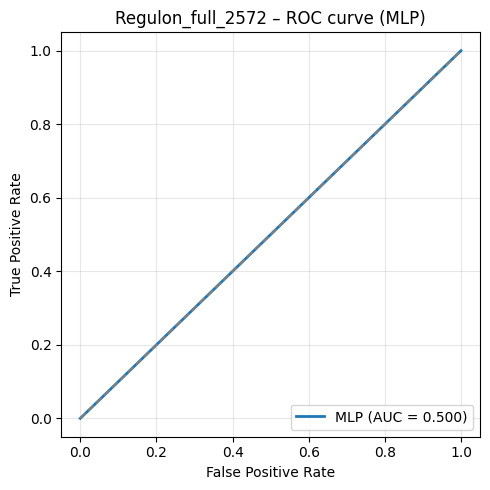

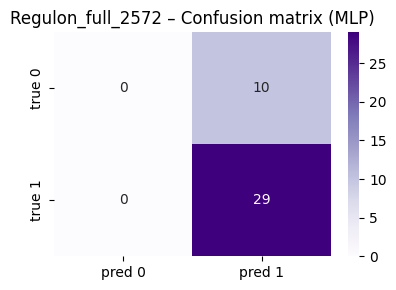


Results for regulons:
subtype: Regulon_full_2572
model: mlp
n_genes: 2534
accuracy: 0.7435897435897436
auc: 0.5


In [ ]:
results_regulon = run_mlp_on_subtype(
    regulon_full,
    gene_expr,
    y,
    subtype_name="Regulon_full_2572",
    hidden_layers=(64,),
    alpha=1e-3,
    max_iter=400,
    random_state=None
)

print("\nResults for regulons:")
for k, v in results_regulon.items():
    if k not in {"confusion_mat"}:
        print(f"{k}: {v}")

High confidence regulons feature set

In [ ]:
hc_regulons = f"{filepath}/Data/TF-Decoupler-RegulatedGenes/feature_set_regulons.csv"
reg_df     = pd.read_csv(hc_regulons, header=0, usecols=[0], dtype=str)
reg_genes  = (reg_df.iloc[:, 0]
                      .str.strip()
                      .str.split(".").str[0]
                      .str.upper()
                      .dropna()
                      .tolist())

print(f"Loaded {len(reg_genes)} regulon genes from file.")

Loaded 1505 regulon genes from file.


In [ ]:
gene_expr.columns = (gene_expr.columns
                               .astype(str)
                               .str.split(".").str[0]
                               .str.upper())

[High Confidence Regulons] MLP
Accuracy = 0.8718,  AUC = 0.9172
Confusion matrix:
 [[ 8  2]
 [ 3 26]] 



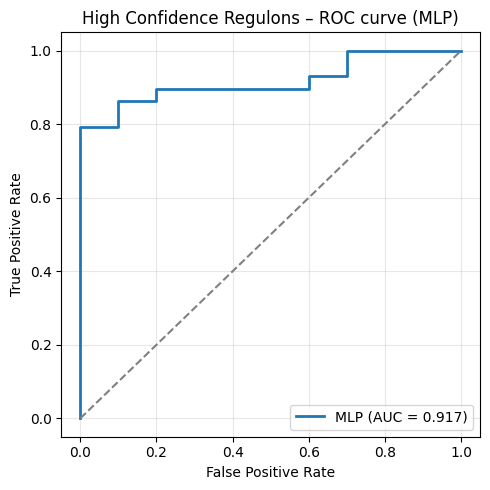

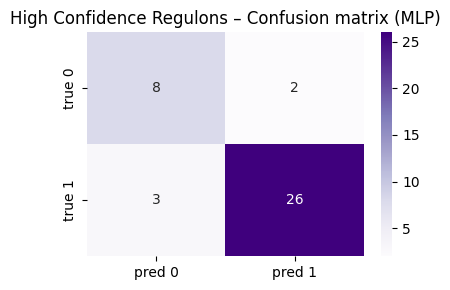

Genes used     : 1504
Accuracy       : 0.8718
AUC-ROC        : 0.9172
Confusion matrix:
 [[ 8  2]
 [ 3 26]]


In [ ]:
regulon_results = run_mlp_on_subtype(
    gene_list_or_path = reg_genes,
    gene_expr_df      = gene_expr,
    y                 = y,
    subtype_name      = "High Confidence Regulons",
    hidden_layers     = (128, 64),
    alpha             = 1e-3,          # L2
    max_iter          = 400,
    random_state      = 42
)

print(f"Genes used     : {regulon_results['n_genes']}")
print(f"Accuracy       : {regulon_results['accuracy']:.4f}")
print(f"AUC-ROC        : {regulon_results['auc']:.4f}")
print("Confusion matrix:\n", regulon_results['confusion_mat'])

Medium Confidence regulons gene set

In [ ]:
regulons_mc = f"{filepath}/Data/TF-Decoupler-RegulatedGenes/feature_set_regulons_med_confidence.csv"
reg_df     = pd.read_csv(regulons_mc, header=0, usecols=[0], dtype=str)   # adjust header/sep if needed
reg_genes  = (reg_df.iloc[:, 0]
                      .str.strip()             # trim spaces
                      .str.split(".").str[0]   # drop Ensembl version        (ENSG…42.5 → ENSG…42)
                      .str.upper()             # ensure same case as gene_expr
                      .dropna()
                      .tolist())

print(f"Loaded {len(reg_genes)} regulon genes from file.")

Loaded 2706 regulon genes from file.


In [ ]:
gene_expr.columns = (gene_expr.columns
                               .astype(str)
                               .str.split(".").str[0]
                               .str.upper())

[Medium Confidence Regulons] MLP
Accuracy = 0.8462,  AUC = 0.9379
Confusion matrix:
 [[ 7  3]
 [ 3 26]] 



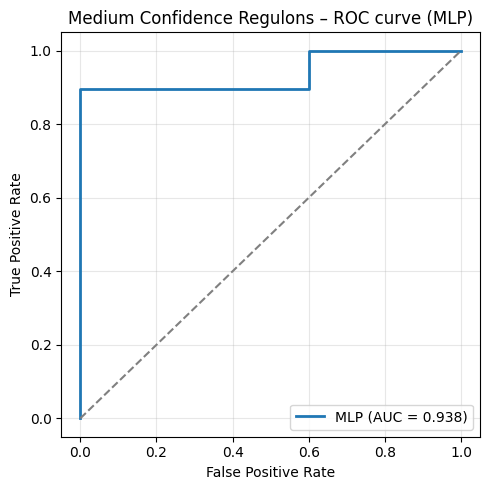

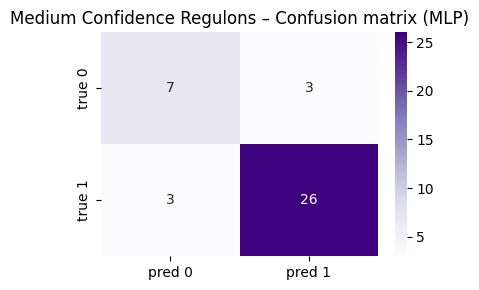

Genes used     : 2702
Accuracy       : 0.8462
AUC-ROC        : 0.9379
Confusion matrix:
 [[ 7  3]
 [ 3 26]]


In [ ]:
regulon_results = run_mlp_on_subtype(
    gene_list_or_path = reg_genes,
    gene_expr_df      = gene_expr,
    y                 = y,
    subtype_name      = "Medium Confidence Regulons",
    hidden_layers     = (128, 64),
    alpha             = 1e-3,          # L2
    max_iter          = 400,
    random_state      = 42
)

print(f"Genes used     : {regulon_results['n_genes']}")
print(f"Accuracy       : {regulon_results['accuracy']:.4f}")
print(f"AUC-ROC        : {regulon_results['auc']:.4f}")
print("Confusion matrix:\n", regulon_results['confusion_mat'])

ABC confidence - new

In [ ]:
regulons_abc = f"{filepath}/Data/TF-Decoupler-RegulatedGenes/feature_set_regulons_confidence_abc.csv"
reg_df     = pd.read_csv(regulons_abc, header=0, usecols=[0], dtype=str)
reg_genes  = (reg_df.iloc[:, 0]
                      .str.strip()
                      .str.split(".").str[0]
                      .str.upper()
                      .dropna()
                      .tolist())

print(f"Loaded {len(reg_genes)} regulon genes from file.")

Loaded 4130 regulon genes from file.


In [ ]:
gene_expr.columns = (gene_expr.columns
                               .astype(str)
                               .str.split(".").str[0]
                               .str.upper())

[ABC Confidence Regulons] MLP
Accuracy = 0.9231,  AUC = 0.9517
Confusion matrix:
 [[10  0]
 [ 3 26]] 



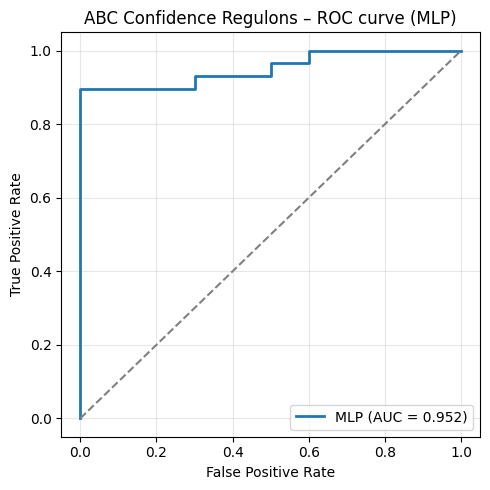

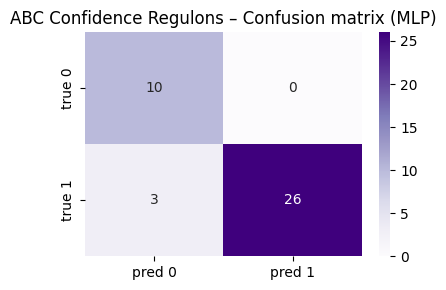

Genes used     : 4126
Accuracy       : 0.9231
AUC-ROC        : 0.9517
Confusion matrix:
 [[10  0]
 [ 3 26]]


In [ ]:
regulon_results = run_mlp_on_subtype(
    gene_list_or_path = reg_genes,
    gene_expr_df      = gene_expr,
    y                 = y,
    subtype_name      = "ABC Confidence Regulons",
    hidden_layers     = (128, 64),
    alpha             = 1e-3,          # L2
    max_iter          = 400,
    random_state      = 42
)

print(f"Genes used     : {regulon_results['n_genes']}")
print(f"Accuracy       : {regulon_results['accuracy']:.4f}")
print(f"AUC-ROC        : {regulon_results['auc']:.4f}")
print("Confusion matrix:\n", regulon_results['confusion_mat'])